<a href="https://colab.research.google.com/github/rozario-lamperouge/DeepLearningCourse/blob/main/Rnn_Smart_Grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks & RNN for Smart Grid Data

## Part 1: Neural Network Architectures for Smart Grid Data

### What is a Smart Grid?
A smart grid is an electrical grid with automation, communication, and IT systems that can monitor power flows from points of generation to points of consumption.

### Key Smart Grid Data Types:
- **Load data**: Power consumption patterns
- **Generation data**: Power production (solar, wind, etc.)
- **Voltage/Frequency**: Grid stability metrics
- **Weather data**: Temperature, solar irradiance
- **Pricing**: Real-time electricity prices

In [ ]:
# Install required packages
!pip install -q tensorflow numpy pandas matplotlib scikit-learn seaborn

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


### 1.1 Load Real-World Smart Grid Dataset

We'll use the **UCI Individual Household Electric Power Consumption Dataset**:
- **Source**: UCI Machine Learning Repository
- **Period**: December 2006 - November 2010 (4 years)
- **Frequency**: 1-minute measurements
- **Location**: Household in France
- **Features**: Global active power, reactive power, voltage, intensity, sub-metering

**Dataset Description:**
This dataset contains 2,075,259 measurements gathered in a house located in Sceaux (7km from Paris, France) between December 2006 and November 2010.

In [ ]:
# Download the dataset
import os
from urllib.request import urlretrieve
import zipfile

# Dataset URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
zip_path = 'household_power_consumption.zip'
data_path = 'household_power_consumption.txt'

# Download if not exists
if not os.path.exists(data_path):
    print("Downloading dataset...")
    urlretrieve(url, zip_path)

    # Extract
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')

    # Clean up
    os.remove(zip_path)
    print("Download complete!")
else:
    print("Dataset already exists!")

Extracting...
Download complete!


In [ ]:
# Load and preprocess the data
print("Loading dataset...")

# Read the data
df_raw = pd.read_csv(
    data_path,
    sep=';',
    parse_dates={'timestamp': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False,
    na_values=['?'],
    index_col='timestamp'
)

print(f"Raw data shape: {df_raw.shape}")
print(f"Date range: {df_raw.index.min()} to {df_raw.index.max()}")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nMissing values:")
print(df_raw.isnull().sum())

Loading dataset...
Raw data shape: (2075259, 7)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00

Columns: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

Missing values:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


## **Dataset Features**



1. Date & Time : Exact timestamp & Minute-level energy consumption
2. Global Active Power (kW) : Actual electricity consumed.
3. Global Reactive Power : Power stored and released by electrical components.
4. Voltage (V) : Average voltage per minute.
5. Global Intensity (A) : Current flow.
6. Sub_metering_1 : Kitchen appliances-Dishwasher, Oven, Microwave
7. Sub_metering_2 : Laundry/utility appliances-Refrigirator, Washing Machine, Dryer
8. Sub_metering_3 : Heavy loads: Water heater, Air conditioner




In [ ]:
# Display first few rows
df_raw.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


###Cleaning

In [ ]:
# Handle missing values
df_clean = df_raw.copy()

# Forward fill missing values (reasonable for time series)
df_clean = df_clean.fillna(method='ffill')

In [ ]:
# Drop any remaining NaN rows
df_clean = df_clean.dropna()

print(f"After cleaning: {df_clean.shape[0]} rows")
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

After cleaning: 2075259 rows
Missing values after cleaning: 0


### Resampling

This process is crucial for reducing noise, computational load, and shifting the focus from fine-grained details to broader trends, which is often more practical for grid-level forecasting in smart grid applications.



In [ ]:
# Resample to hourly data (average over each hour)
# This reduces computational load and is more practical for grid-level forecasting
print("\nResampling to hourly frequency...")
df_hourly = df_clean.resample('H').mean()

# Drop any rows with missing values after resampling
df_hourly = df_hourly.dropna()

print(f"Hourly data shape: {df_hourly.shape}")
print(f"Date range: {df_hourly.index.min()} to {df_hourly.index.max()}")

df_hourly.head()


Resampling to hourly frequency...
Hourly data shape: (34589, 7)
Date range: 2006-12-16 17:00:00 to 2010-11-26 21:00:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
timestamp,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


###Feature Engineering

In [ ]:
# Feature engineering
print("Creating features...\n")

# Create time-based features
df = df_hourly.copy()
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

Creating features...



**Why use cyclical features for time?**

When we represent time features like 'hour' numerically (0, 1, 2, ..., 23), a machine learning model might incorrectly interpret the relationship between hours.

**For example:**

**Linear Relationship Problem:** The hour 23 is numerically far from 0, but in reality, 23:00 is only one hour away from 00:00. A model treating hour as a simple linear variable might assume a large difference between these two points.

**Seasonality:** Time features inherently have a cyclical pattern. Morning hours are similar to morning hours on other days, and night hours are similar to other night hours. A linear encoding doesn't capture this 'closeness' at the boundaries of the cycle.

**How Sine and Cosine Transformations Solve This:**
By using sine and cosine transformations, we convert a single linear time feature into two new features that preserve the cyclical nature and the 'closeness' at the cycle boundaries. Here's how the formula works:

2 * **np.pi**: This represents a full circle in radians. When you normalize a time unit (like hours in a day) to a full circle, you map the entire cycle (0 to 23 hours) to the range of 0 to 2π radians.

**df['hour'] / 24**: This part normalizes the hour value to be a fraction of a full day (24 hours).

**For example:**
- Hour 0 becomes 0 / 24 = 0
- Hour 6 becomes 6 / 24 = 0.25
- Hour 12 becomes 12 / 24 = 0.5
- Hour 18 becomes 18 / 24 = 0.75
- Hour 23 becomes 23 / 24 ≈ 0.958

np.sin(...) and np.cos(...): Applying sine and cosine to this normalized value maps each hour to a unique point on a 2D circle. For example:

- Hour 0 (00:00): sin(0) is 0, cos(0) is 1. The point is (0, 1).
- Hour 6 (06:00): sin(2π * 0.25) = sin(π/2) is 1, cos(2π * 0.25) = cos(π/2) is 0. The point is (1, 0).
- Hour 12 (12:00): The point is (0, -1).
- Hour 23 (23:00): sin(2π * 23/24) ≈ -0.25, cos(2π * 23/24) ≈ 0.97. This point is close to (0,1) for Hour 0.

Benefits:

1. Captures Periodicity: The sine and cosine values smoothly transition around the cycle, with hour 23 having similar sine/cosine values to hour 0. This allows the model to understand that these hours are close in time.

2. Unique Representation: Using both sine and cosine values ensures that each hour within the 24-hour cycle has a unique coordinate pair. If you only used sine, for example, hour 6 and hour 18 would both have a sine value of 1 and -1 respectively, making them indistinguishable from other points if only sine was used.

This technique is also applied to day_of_week (dividing by 7 for 7 days) and month (dividing by 12 for 12 months) for the exact same reasons, to capture their cyclical nature effectively for the machine learning model.

In [ ]:
# Create cyclical features for hour (to capture circular nature of time)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Create cyclical features for day of week
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Create cyclical features for month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Rename columns for clarity
df = df.rename(columns={
    'Global_active_power': 'power_consumption',
    'Global_reactive_power': 'reactive_power',
    'Voltage': 'voltage',
    'Global_intensity': 'current',
    'Sub_metering_1': 'kitchen',
    'Sub_metering_2': 'laundry',
    'Sub_metering_3': 'water_heater_ac'
})

# Reset index to make timestamp a column
df = df.reset_index()

print(f"Final dataset shape: {df.shape}")
print(f"\nFeatures: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

# Display sample
df.head(10)

Final dataset shape: (34589, 19)

Features: ['timestamp', 'power_consumption', 'reactive_power', 'voltage', 'current', 'kitchen', 'laundry', 'water_heater_ac', 'hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']

Data types:
timestamp            datetime64[ns]
power_consumption           float64
reactive_power              float64
voltage                     float64
current                     float64
kitchen                     float64
laundry                     float64
water_heater_ac             float64
hour                          int32
day_of_week                   int32
month                         int32
day_of_year                   int32
is_weekend                    int64
hour_sin                    float64
hour_cos                    float64
day_sin                     float64
day_cos                     float64
month_sin                   float64
month_cos                   float64
dtype: obj

,timestamp,power_consumption,reactive_power,voltage,current,kitchen,laundry,water_heater_ac,hour,day_of_week,month,day_of_year,is_weekend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,350,1,-0.965926,-2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,350,1,-1.000000,-1.836970e-16,-0.974928,-0.222521,-2.449294e-16,1.0
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,350,1,-0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,350,1,-0.866025,5.000000e-01,-0.974928,-0.222521,-2.449294e-16,1.0
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,350,1,-0.707107,7.071068e-01,-0.974928,-0.222521,-2.449294e-16,1.0
5,2006-12-16 22:00:00,2.200133,0.056167,238.760000,9.523333,0.0,0.133333,4.433333,22,5,12,350,1,-0.500000,8.660254e-01,-0.974928,-0.222521,-2.449294e-16,1.0
6,2006-12-16 23:00:00,2.061600,0.071433,240.619667,8.896667,0.0,0.083333,0.000000,23,5,12,350,1,-0.258819,9.659258e-01,-0.974928,-0.222521,-2.449294e-16,1.0
7,2006-12-17 00:00:00,1.882467,0.102433,240.961833,8.126667,0.0,0.466667,0.000000,0,6,12,351,1,0.000000,1.000000e+00,-0.781831,0.623490,-2.449294e-16,1.0
8,2006-12-17 01:00:00,3.349400,0.136933,240.448333,14.246667,0.0,25.233333,0.000000,1,6,12,351,1,0.258819,9.659258e-01,-0.781831,0.623490,-2.449294e-16,1.0
9,2006-12-17 02:00:00,1.587267,0.078233,245.818667,6.870000,0.0,0.566667,0.000000,2,6,12,351,1,0.500000,8.660254e-01,-0.781831,0.623490,-2.449294e-16,1.0


In [ ]:
# Dataset statistics
print("Dataset Statistics:")
print(df.describe())

Dataset Statistics:
                 timestamp  power_consumption  reactive_power       voltage  \
count                34589       34589.000000    34589.000000  34589.000000   
mean   2008-12-06 07:00:00           1.086200        0.123326    240.841505   
min    2006-12-16 17:00:00           0.124000        0.000000    225.834500   
25%    2007-12-12 00:00:00           0.341267        0.077667    239.197167   
50%    2008-12-06 07:00:00           0.799533        0.106767    240.984500   
75%    2009-12-01 14:00:00           1.574967        0.149367    242.691833   
max    2010-11-26 21:00:00           6.560533        0.774333    251.902000   
std                    NaN           0.894942        0.067221      2.999127   

            current       kitchen       laundry  water_heater_ac  \
count  34589.000000  34589.000000  34589.000000     34589.000000   
mean       4.604360      1.110951      1.287914         6.416515   
min        0.503333      0.000000      0.000000         0.000000

## Exploratory Data Analytics

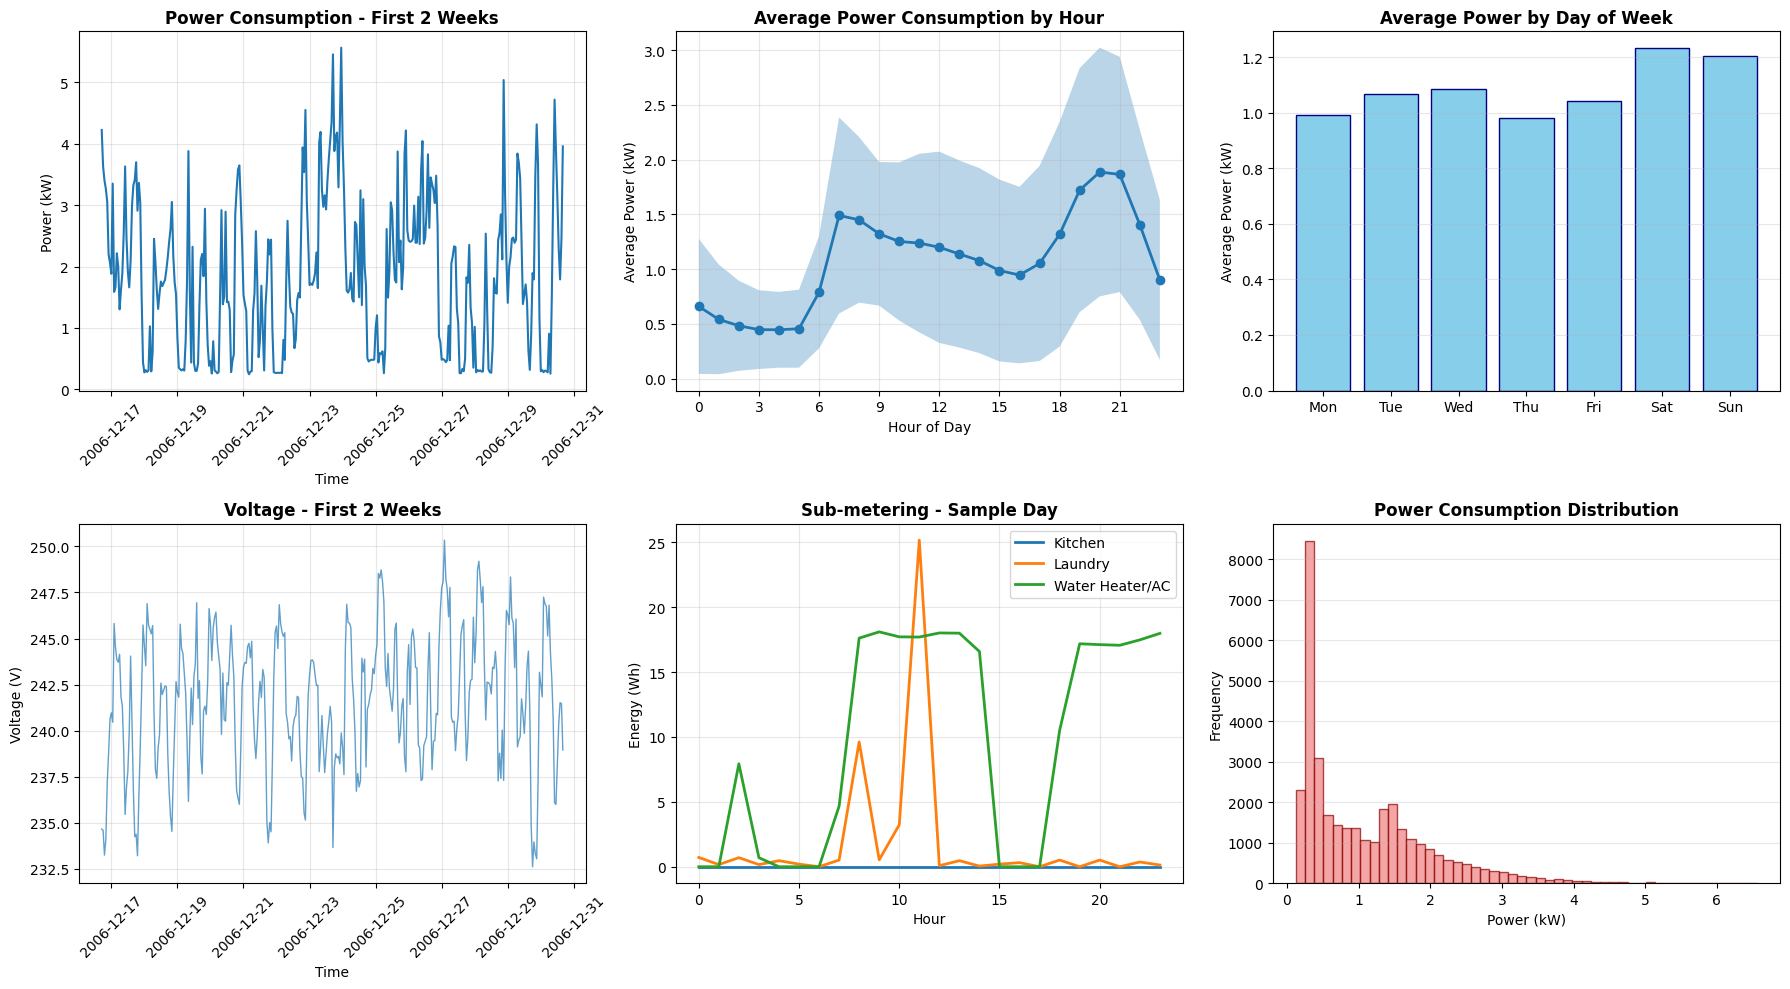


📊 Power Consumption Statistics:
  Mean: 1.086 kW
  Std:  0.895 kW
  Min:  0.124 kW
  Max:  6.561 kW


In [ ]:
# Visualize power consumption patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Time series of power consumption (first 2 weeks)
n_hours = 24 * 14  # 2 weeks
axes[0, 0].plot(df['timestamp'][:n_hours], df['power_consumption'][:n_hours], linewidth=1.5)
axes[0, 0].set_title('Power Consumption - First 2 Weeks', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Power (kW)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Daily pattern (average by hour)
hourly_avg = df.groupby('hour')['power_consumption'].mean()
hourly_std = df.groupby('hour')['power_consumption'].std()
axes[0, 1].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
axes[0, 1].fill_between(hourly_avg.index,
                         hourly_avg.values - hourly_std.values,
                         hourly_avg.values + hourly_std.values,
                         alpha=0.3)
axes[0, 1].set_title('Average Power Consumption by Hour', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Power (kW)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 3))

# Plot 3: Weekly pattern (average by day of week)
daily_avg = df.groupby('day_of_week')['power_consumption'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 2].bar(range(7), daily_avg.values, color='skyblue', edgecolor='navy')
axes[0, 2].set_xticks(range(7))
axes[0, 2].set_xticklabels(day_names)
axes[0, 2].set_title('Average Power by Day of Week', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Average Power (kW)')
axes[0, 2].grid(axis='y', alpha=0.3)

# Plot 4: Voltage over time (sample)
axes[1, 0].plot(df['timestamp'][:n_hours], df['voltage'][:n_hours], linewidth=1, alpha=0.7)
axes[1, 0].set_title('Voltage - First 2 Weeks', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Voltage (V)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Sub-metering comparison (sample day)
sample_day = df[df['timestamp'].dt.date == df['timestamp'].dt.date.iloc[100]]
axes[1, 1].plot(sample_day['hour'], sample_day['kitchen'], label='Kitchen', linewidth=2)
axes[1, 1].plot(sample_day['hour'], sample_day['laundry'], label='Laundry', linewidth=2)
axes[1, 1].plot(sample_day['hour'], sample_day['water_heater_ac'], label='Water Heater/AC', linewidth=2)
axes[1, 1].set_title('Sub-metering - Sample Day', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Energy (Wh)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Power distribution
axes[1, 2].hist(df['power_consumption'], bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[1, 2].set_title('Power Consumption Distribution', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Power (kW)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print("\n📊 Power Consumption Statistics:")
print(f"  Mean: {df['power_consumption'].mean():.3f} kW")
print(f"  Std:  {df['power_consumption'].std():.3f} kW")
print(f"  Min:  {df['power_consumption'].min():.3f} kW")
print(f"  Max:  {df['power_consumption'].max():.3f} kW")

###Data Pre-Processing

In [ ]:
# Select features and target
# We'll use temporal features and sub-metering data to predict total power consumption
feature_cols = [
    'hour_sin', 'hour_cos',           # Cyclical hour encoding
    'day_sin', 'day_cos',             # Cyclical day of week encoding
    'month_sin', 'month_cos',         # Cyclical month encoding
    'is_weekend',                      # Weekend indicator
    'voltage',                         # Grid voltage
    'current',                         # Current intensity
    'kitchen',                         # Kitchen sub-meter
    'laundry',                         # Laundry sub-meter
    'water_heater_ac'                  # Water heater/AC sub-meter
]

target_col = 'power_consumption'

In [ ]:
# Create feature matrix and target vector
X = df[feature_cols].values
y = df[target_col].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nSelected features: {feature_cols}")
print(f"Target: {target_col}")

# Check for any remaining missing values
print(f"\nMissing values in features: {np.isnan(X).sum()}")
print(f"Missing values in target: {np.isnan(y).sum()}")

Features shape: (34589, 12)
Target shape: (34589,)

Selected features: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'voltage', 'current', 'kitchen', 'laundry', 'water_heater_ac']
Target: power_consumption

Missing values in features: 0
Missing values in target: 0


In [ ]:
# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, shuffle=False)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
# This scaler transforms data such that its mean is 0 and its standard deviation is 1 (often called Z-score normalization).
# This is vital for neural networks, as it helps them converge faster
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"\nScaled features range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print(f"Scaled target range: [{y_train_scaled.min():.2f}, {y_train_scaled.max():.2f}]")


Train set: 24225 samples
Validation set: 5175 samples
Test set: 5189 samples

Scaled features range: [-4.80, 13.13]
Scaled target range: [-1.03, 5.90]


## Simple Feed Forward Network

In [ ]:
def build_simple_nn(input_dim):
    """
    Simple 2-layer feedforward neural network
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', name='hidden1'),
        layers.Dense(32, activation='relu', name='hidden2'),
        layers.Dense(1, name='output')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build model
model_simple = build_simple_nn(X_train_scaled.shape[1])
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
print("Training Simple Neural Network...")
history_simple = model_simple.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    verbose=1
)

Training Simple Neural Network...
Epoch 1/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0010 - val_mae: 0.0240
Epoch 2/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0010 - val_mae: 0.0244
Epoch 3/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.8681e-04 - mae: 0.0225 - val_loss: 9.9778e-04 - val_mae: 0.0239
Epoch 4/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8727e-04 - mae: 0.0212 - val_loss: 8.6368e-04 - val_mae: 0.0221
Epoch 5/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.0768e-04 - mae: 0.0200 - val_loss: 7.5559e-04 - val_mae: 0.0206
Epoch 6/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.4289e-04 - mae: 0.0190 - val_loss: 7.3837e-04 - val_mae: 0.0202
Epoch 7/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.0753e-04 - mae: 0.0184 - val_loss: 6.7733e-04 - val_mae: 0.0196
Epoch 8/100
758/758 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.8122e-04 - mae: 0.0180 - val_l

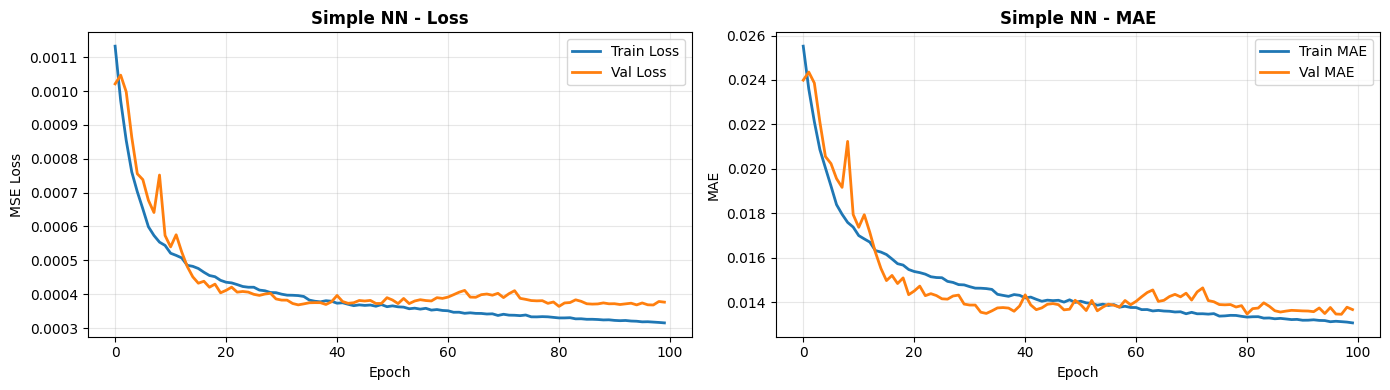

In [ ]:
# Plot training history
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # MAE
    axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[1].set_title(f'{model_name} - MAE', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_simple, "Simple NN")

In [ ]:
def evaluate_model(model, X_test, y_test, scaler_y, model_name):
    """
    Evaluate model and return metrics
    """
    # Predictions
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.3f} kW")
    print(f"  MAE:  {mae:.3f} kW")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'predictions': y_pred.flatten()
    }

# Evaluate all models
results = []
results.append(evaluate_model(model_simple, X_test_scaled, y_test, scaler_y, "Simple NN"))


Simple NN Performance:
  RMSE: 0.023 kW
  MAE:  0.014 kW
  R²:   0.9990
  MAPE: 2.06%



Simple NN Performance:
  RMSE: 0.023 kW
  MAE:  0.014 kW
  R²:   0.9990
  MAPE: 2.06%


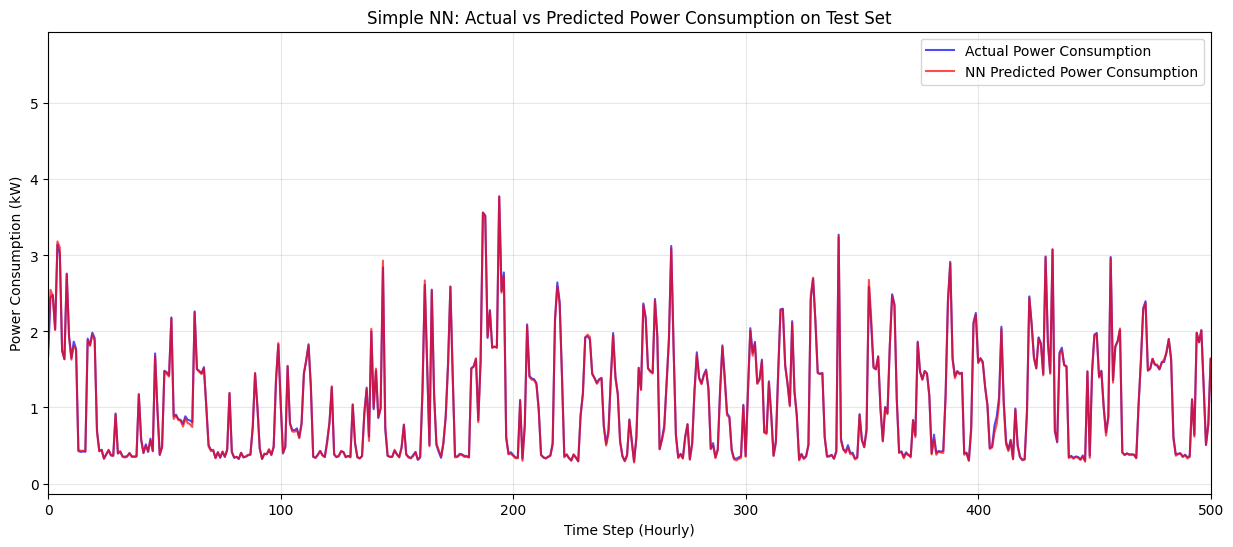

In [ ]:
# Retrieve results from the already evaluated Simple NN
simple_nn_results = results[0]

# Visualize predictions vs actual values on a segment of the test set
y_pred_simple = simple_nn_results['predictions']

plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Power Consumption', color='blue', alpha=0.7)
plt.plot(y_pred_simple, label='NN Predicted Power Consumption', color='red', alpha=0.7)
plt.title('Simple NN: Actual vs Predicted Power Consumption on Test Set')
plt.xlabel('Time Step (Hourly)')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 500) # Show first 500 hours for better visibility
plt.show()

## Part 2: Sequence Modeling with RNN for Smart Grid Time Series

### Why Sequence Models for Smart Grid?

Smart grid data is inherently **temporal**:
- Power consumption has strong **autocorrelation** (current value depends on past values)
- **Seasonal patterns** (daily, weekly, yearly cycles)
- **Trend information** captured over time

RNNs can capture these temporal dependencies that feedforward networks miss.

### Types of Sequence Models:
1. **Vanilla RNN**: Basic recurrent architecture
2. **LSTM** (Long Short-Term Memory): Handles long-term dependencies
3. **GRU** (Gated Recurrent Unit): Simplified LSTM
4. **Bidirectional RNN**: Processes sequences in both direction

### 2.1 Prepare Sequence Data

For sequence models, we need to create sequences of past observations to predict future values.

In [ ]:
def create_sequences(data, target, seq_length, forecast_horizon=1):
    """
    Create sequences for time series prediction

    Args:
        data: Feature array
        target: Target array
        seq_length: Number of past time steps to use
        forecast_horizon: Number of steps ahead to predict

    Returns:
        X: Sequences of shape (n_samples, seq_length, n_features)
        y: Targets of shape (n_samples,)
    """
    X, y = [], []

    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length + forecast_horizon - 1])

    return np.array(X), np.array(y)

# Parameters
SEQ_LENGTH = 24  # Use past 24 hours to predict
FORECAST_HORIZON = 1  # Predict 1 hour ahead

print(f"Sequence Length: {SEQ_LENGTH} hours")
print(f"Forecast Horizon: {FORECAST_HORIZON} hour(s)")

# Prepare sequence data (before scaling)
# Use all data for sequence creation
all_X = df[feature_cols].values
all_y = df[target_col].values

# Create sequences
X_seq, y_seq = create_sequences(all_X, all_y, SEQ_LENGTH, FORECAST_HORIZON)

print(f"\nSequence data shape: {X_seq.shape}")
print(f"Target shape: {y_seq.shape}")
print(f"\nInterpretation: {X_seq.shape[0]} sequences, each with {X_seq.shape[1]} time steps and {X_seq.shape[2]} features")

Sequence Length: 24 hours
Forecast Horizon: 1 hour(s)

Sequence data shape: (34565, 24, 12)
Target shape: (34565,)

Interpretation: 34565 sequences, each with 24 time steps and 12 features


In [ ]:
# Split sequences (temporal split - no shuffling)
train_size = int(0.7 * len(X_seq))
val_size = int(0.15 * len(X_seq))

X_seq_train = X_seq[:train_size]
y_seq_train = y_seq[:train_size]

X_seq_val = X_seq[train_size:train_size + val_size]
y_seq_val = y_seq[train_size:train_size + val_size]

X_seq_test = X_seq[train_size + val_size:]
y_seq_test = y_seq[train_size + val_size:]

print(f"Train sequences: {X_seq_train.shape[0]}")
print(f"Validation sequences: {X_seq_val.shape[0]}")
print(f"Test sequences: {X_seq_test.shape[0]}")

# Scale sequences
# Reshape for scaling
n_samples_train = X_seq_train.shape[0]
n_samples_val = X_seq_val.shape[0]
n_samples_test = X_seq_test.shape[0]

X_seq_train_2d = X_seq_train.reshape(-1, X_seq_train.shape[-1])
X_seq_val_2d = X_seq_val.reshape(-1, X_seq_val.shape[-1])
X_seq_test_2d = X_seq_test.reshape(-1, X_seq_test.shape[-1])

# Fit scaler on training data only
scaler_X_seq = StandardScaler()
scaler_y_seq = StandardScaler()

X_seq_train_scaled = scaler_X_seq.fit_transform(X_seq_train_2d).reshape(n_samples_train, SEQ_LENGTH, -1)
X_seq_val_scaled = scaler_X_seq.transform(X_seq_val_2d).reshape(n_samples_val, SEQ_LENGTH, -1)
X_seq_test_scaled = scaler_X_seq.transform(X_seq_test_2d).reshape(n_samples_test, SEQ_LENGTH, -1)

y_seq_train_scaled = scaler_y_seq.fit_transform(y_seq_train.reshape(-1, 1)).flatten()
y_seq_val_scaled = scaler_y_seq.transform(y_seq_val.reshape(-1, 1)).flatten()
y_seq_test_scaled = scaler_y_seq.transform(y_seq_test.reshape(-1, 1)).flatten()

print(f"\nScaled sequence shape: {X_seq_train_scaled.shape}")

Train sequences: 24195
Validation sequences: 5184
Test sequences: 5186

Scaled sequence shape: (24195, 24, 12)


### Build RNN Models

#### Model 1: Simple RNN

In [ ]:
def build_simple_rnn(seq_length, n_features):
    """
    Simple RNN model
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, n_features)),
        layers.SimpleRNN(64, activation='tanh', return_sequences=True),
        layers.SimpleRNN(32, activation='tanh'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Build model
model_rnn = build_simple_rnn(SEQ_LENGTH, X_seq_train_scaled.shape[2])
model_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 24, 64)         │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Training Simple RNN...
Epoch 1/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3777 - mae: 0.4251 - val_loss: 0.3539 - val_mae: 0.4202
Epoch 2/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3527 - mae: 0.4071 - val_loss: 0.3466 - val_mae: 0.4180
Epoch 3/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.3399 - mae: 0.3983 - val_loss: 0.3433 - val_mae: 0.4155
Epoch 4/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.3322 - mae: 0.3934 - val_loss: 0.3404 - val_mae: 0.4136
Epoch 5/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.3251 - mae: 0.3887 - val_loss: 0.3417 - val_mae: 0.4161
Epoch 6/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.3186 - mae: 0.3848 - val_loss: 0.3406 - val_mae: 0.4148
Epoch 7/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.3133 - mae: 0.3815 - val_loss: 0.3453 - val_mae: 0.4165
Epoch 8/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.3077 - mae: 0.3787 - val_loss: 0.3451 - val_mae: 0.4179
Epoch 9/50
379/379 ━━━

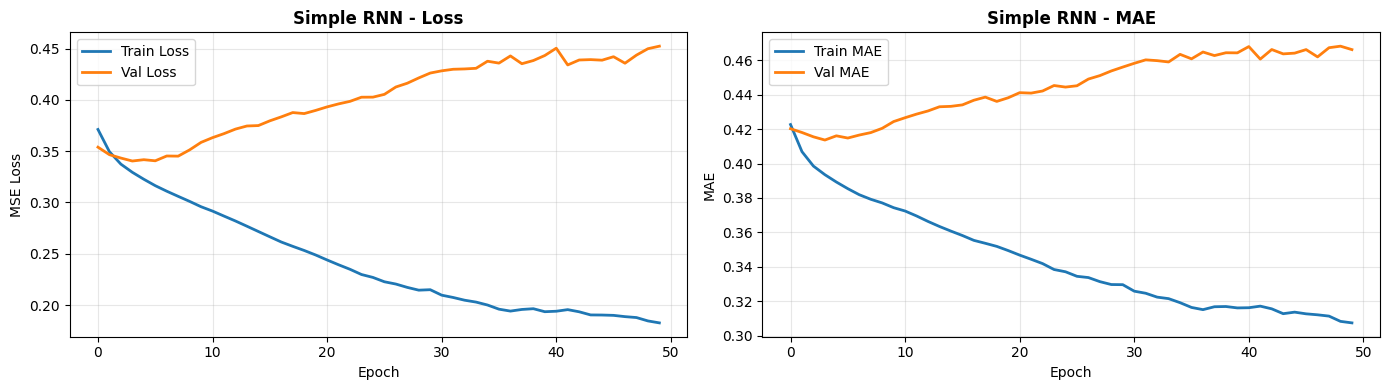

In [ ]:
# Train Simple RNN
print("Training Simple RNN...")
history_rnn = model_rnn.fit(
    X_seq_train_scaled, y_seq_train_scaled,
    validation_data=(X_seq_val_scaled, y_seq_val_scaled),
    epochs=50,
    batch_size=64,
    verbose=1
)

plot_training_history(history_rnn, "Simple RNN")

#### Model 2: LSTM

In [ ]:
def build_lstm(seq_length, n_features):
    """
    LSTM model - better at capturing long-term dependencies
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, n_features)),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

model_lstm = build_lstm(SEQ_LENGTH, X_seq_train_scaled.shape[2])
model_lstm.summary()

In [ ]:
# Train LSTM
print("Training LSTM...")
history_lstm = model_lstm.fit(
    X_seq_train_scaled, y_seq_train_scaled,
    validation_data=(X_seq_val_scaled, y_seq_val_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_training_history(history_lstm, "LSTM")

#### Model 3: GRU

In [ ]:
def build_gru(seq_length, n_features):
    """
    GRU model - more efficient than LSTM, similar performance
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, n_features)),
        layers.GRU(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.GRU(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

model_gru = build_gru(SEQ_LENGTH, X_seq_train_scaled.shape[2])
model_gru.summary()

In [ ]:
# Train GRU
print("Training GRU...")
history_gru = model_gru.fit(
    X_seq_train_scaled, y_seq_train_scaled,
    validation_data=(X_seq_val_scaled, y_seq_val_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_training_history(history_gru, "GRU")

#### Model 4: Bidirectional LSTM

In [ ]:
def build_bidirectional_lstm(seq_length, n_features):
    """
    Bidirectional LSTM - processes sequences in both directions
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, n_features)),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.2),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

model_bilstm = build_bidirectional_lstm(SEQ_LENGTH, X_seq_train_scaled.shape[2])
model_bilstm.summary()

In [ ]:
# Train Bidirectional LSTM
print("Training Bidirectional LSTM...")
history_bilstm = model_bilstm.fit(
    X_seq_train_scaled, y_seq_train_scaled,
    validation_data=(X_seq_val_scaled, y_seq_val_scaled),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plot_training_history(history_bilstm, "Bidirectional LSTM")

###Evaluate RNN Models

In [ ]:
# Evaluate all RNN models
rnn_results = []
rnn_results.append(evaluate_model(model_rnn, X_seq_test_scaled, y_seq_test, scaler_y_seq, "Simple RNN"))
rnn_results.append(evaluate_model(model_lstm, X_seq_test_scaled, y_seq_test, scaler_y_seq, "LSTM"))
rnn_results.append(evaluate_model(model_gru, X_seq_test_scaled, y_seq_test, scaler_y_seq, "GRU"))
rnn_results.append(evaluate_model(model_bilstm, X_seq_test_scaled, y_seq_test, scaler_y_seq, "Bidirectional LSTM"))

In [ ]:
# Compare RNN models
rnn_comparison_df = pd.DataFrame([{
    'Model': r['model'],
    'RMSE (kW)': f"{r['rmse']:.3f}",
    'MAE (kW)': f"{r['mae']:.3f}",
    'R²': f"{r['r2']:.4f}",
    'MAPE (%)': f"{r['mape']:.2f}"
} for r in rnn_results])

print("\nRNN Model Comparison:")
print(rnn_comparison_df.to_string(index=False))

In [ ]:
# Visualize RNN predictions
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

n_plot = 168  # One week
for idx, result in enumerate(rnn_results):
    axes[idx].plot(y_seq_test[:n_plot], label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(result['predictions'][:n_plot], label='Predicted', linewidth=2, alpha=0.7)
    axes[idx].set_title(f"{result['model']} - Predictions vs Actual (First Week)",
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Step (Hours)')
    axes[idx].set_ylabel('Power (kW)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].text(0.02, 0.98, f"RMSE: {result['rmse']:.3f} kW\nR²: {result['r2']:.4f}",
                  transform=axes[idx].transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()